Workflow:
1. Import module and global settings
2. Place for reusable custom functions
3. Reading treadmill behavior csv files
4. Exract speed, lick event
5. Calculate COM of Lick from RZ
5. Transformation of data structure for statistics and visualization
6. Statistics
7. Visualization

In [1]:
# Import module and global settings

# Import modules
import dabest
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tkinter import Tk, filedialog

# Global settings
RZFLOOR = 150 #cm
RZCEILING = 170 #cm
LICK_START_CUTOFF = 30 #cm
BINNING_WINDOW = 1 #cm or min 

root = Tk()
root.attributes('-topmost', True)  # 將主視窗設置為最上層
root.withdraw()

''

In [2]:
# Place for reusable custom functions

#select file
def select_files_and_get_paths(prompt = "select behavior csv files"):
    """
    Prompt the user to select multiple files using a GUI.

    Parameters:
    prompt (str): The prompt message to display in the file dialog.

    Returns:
    tuple: A tuple containing the paths of the selected files.
    """

    file_paths = []

    while True:

        files = filedialog.askopenfilenames(parent=root, title=prompt, filetypes=[('CSV files', '*.csv')])
        
        if not files:
            break
        file_paths.extend(files)

    return file_paths

# Extract the experiment information from the file path
def extract_experiment_info(file_path):
    """
    Extract experiment condition, Genotype, and mouse ID from the file path.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    tuple: A tuple containing the experiment condition (Treatment), Genotype, and mouse ID.
    """
    # Normalize the file path to use `/` as the separator
    normalized_path = file_path.replace("\\", "/")
    
    # Match the file path using the updated regex
    match = re.search(
    r'/([^/]+)/'                 # 匹配目錄層級，例如 'im(Proximal limb muscles)180/'
    r'(?P<Genotype>[^/]+)_'      # 匹配 genotype，例如 'PVLMO3'
    r'(?P<Treatment>[^/]+)/'       # 匹配 Treatment，例如 'Baseline' 或 'CTZ'
    r'(?P<mouse_id>[A-Z0-9]+)_'  # 匹配 mouse_id，例如 '1PL001F'
    , normalized_path)

    if match:
        Treatment = match.group('Treatment')
        Genotype = match.group('Genotype')
        mouse_id = match.group('mouse_id')
        return Treatment, Genotype, mouse_id
    else:
        print(f"No valid experiment info found in file path: {file_path}")
        return None, None, None

#read file
def read_file(file_paths):
    """
    Read multiple CSV files and return a dictionary with experiment info as keys and DataFrame as values.

    Parameters:
    file_paths: A tuple containing the paths of the selected files.

    Returns:
    dict: A dictionary where keys are (Treatment, Genotype, mouse_id) tuples and values are DataFrames.
    """
    behavior_csv_data = {}

    for file_path in file_paths:
        # Extract experiment information
        Treatment, Genotype, mouse_id = extract_experiment_info(file_path)

        if Treatment is None or Genotype is None or mouse_id is None:
            print(f"Skipping file due to missing experiment info: {file_path}")
            continue

        # Read the CSV file into a DataFrame
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

        # Add the DataFrame to the dictionary
        key = (Treatment, Genotype, mouse_id)
        
        behavior_csv_data[key] = df

    return behavior_csv_data

# Exract avg speed in a session
def session_avg_speed(df):
    """
    Extract the average speed from the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the behavior data.

    Returns:
    float: The average speed.
    """
    # 將 df 依trial number分組
    grouped = df.groupby(df.columns[1])

    # 找到每一Trial中速度的最大值
    max_values = grouped[df.columns[3]].max()

    #去除異常值
    max_values = max_values[max_values < 100]

    # 將每一Trial中速度的最大值相加後平均
    avg_max = max_values.mean()

    # 返回這個平均值
    return avg_max

def extract_lick_positions(df, lick_start_cutoff=LICK_START_CUTOFF, RzFloor=RZFLOOR, RzCeiling=RZCEILING):
    """
    Extract lick positions (cm) from the DataFrame, applying optional reward zone filtering.

    Parameters:
    df (DataFrame): Input behavior data containing lick events and positions.
    lick_start_cutoff (float): Minimum position (cm) for valid licks. Default is 0.
    RzFloor (float, optional): Lower boundary of the reward zone. If None, no reward zone filtering is applied.
    RzCeiling (float, optional): Upper boundary of the reward zone. If None, no upper limit is applied.

    Returns:
    DataFrame: A single-column DataFrame ('lick_position') listing valid lick positions (cm).
    """
    # Step 0: Ensure no NaN values and validate data types
    required_columns = [1, 2, 4]  # Assuming trial number, position (cm), and lick number columns
    if any(col >= len(df.columns) for col in required_columns):
        raise ValueError("Input DataFrame does not have the required columns.")

    df = df.copy().dropna()
    for col in required_columns:
        if not pd.api.types.is_numeric_dtype(df[df.columns[col]]):
            raise ValueError(f"Column {df.columns[col]} must be numeric.")

    # Step 1: Identify lick events where the lick number increases
    df['prev_lick_number'] = df[df.columns[4]].shift(1)  # Assuming column 4 is lick number
    df['lick_happened'] = df[df.columns[4]] > df['prev_lick_number']
    df['lick_happened'] = df['lick_happened'].fillna(False)

    # Extract positions where licks happen
    df['lick_position'] = df.loc[df['lick_happened'], df.columns[2]]  # Assuming column 2 is position (cm)

    # Step 2: Filter out licks below lick_start_cutoff
    valid_positions = df['lick_position'] > lick_start_cutoff

    # Step 3: Apply reward zone filtering if specified
    if RzFloor is not None:
        valid_positions &= df['lick_position'] < RzFloor

    # Apply combined filters
    df['lick_position'] = df['lick_position'].where(valid_positions)

    # Step 4: Add the first lick position in the reward zone for each trial
    if RzFloor is not None and RzCeiling is not None:
        # 獲取每個試驗中位於獎勵區域的第一個舔舐位置
        first_lick_in_reward_zone = (
            df[(df[df.columns[2]] >= RzFloor) & (df[df.columns[2]] <= RzCeiling)]
            .groupby(df.columns[1])[df.columns[2]]
            .first()
            .dropna()
        )

        # 將這些位置新增到原本的 lick_position 中
        reward_zone_licks = pd.DataFrame({
            df.columns[1]: first_lick_in_reward_zone.index,  # 試驗號
            'lick_position': first_lick_in_reward_zone.values  # 第一個舔舐位置
        })

        # 合併原始舔舐位置與新增的獎勵區域位置
        df = pd.concat([
            df[['lick_position', df.columns[1]]].dropna(),  # 保留原始舔舐位置
            reward_zone_licks  # 新增的獎勵區域位置
        ]).drop_duplicates().reset_index(drop=True)

    # Step 5: Keep only the 'lick_position' and trial number columns
    lick_position_df = df.sort_values(by=[df.columns[1], 'lick_position']).copy()
    lick_position_df.columns = ['lick_position', 'trial']  # Rename columns for clarity
    lick_position_df['lick_position'] = lick_position_df['lick_position'].astype(float)

    return lick_position_df

def licks_statistics(lick_position_df):
    """
    Calculate lick statistics from the DataFrame.

    Parameters:
    lick_position_df (DataFrame): Input licks data of one Treatment containing columns:
                                  'trial' and 'lick_position'.

    Returns:
    lick_stats (DataFrame): A DataFrame containing statistics for each trial:
                            - 'trial': Trial number
                            - 'phase': PreTX(Trial~30), PostTX(Trial31~60)
                            - 'COM': Center of Mass (mean of lick positions)
                            - 'coefficient_of_variation_within_trial': CV (std/mean of lick positions)
    """
    # Ensure no NaN values in the input data
    lick_position_df = lick_position_df.dropna()

    # Group by trial to calculate statistics
    grouped = lick_position_df.groupby('trial')

    # Calculate Center of Mass (mean of lick positions)
    com = grouped['lick_position'].mean()

    # COM Distance from Reward Zone
    com_distance = RZFLOOR - com

    # Calculate Coefficient of Variation (CV = std / mean)
    std = grouped['lick_position'].std()
    cv = std / com
    

    # Create the statistics DataFrame
    lick_stats = pd.DataFrame({
        'trial': com.index,
        'COM': com.values,
        'COM_distance_from_RZ': com_distance.values,
        'coefficient_of_variation_within_trial': cv.values
    })

    lick_stats['phase'] = lick_stats['trial'].apply(
    lambda x: 'PreTX' if 1 <= x <= 30 else ('PostTX' if 31 <= x else None))

    return lick_stats

def convert_to_group_lick_stats(ind_lick_stats_data):
    """
    Convert ind_lick_stats_data to group_lick_stats_data, a long-format DataFrame suitable for dabest analysis.

    Steps:
    1. Remove rows with 'phase' == None.
    2. Group by 'PreTX' and 'PostTX' phases, calculate the average values for each group.
    3. Add 'coefficient_of_variation_between_trial' based on 'COM_distance_from_RZ'.
    4. Flatten the keys in ind_lick_stats_data and add columns 'group' and 'mouse_id'.
    5. Format the final DataFrame for dabest compatibility.

    Parameters:
    ind_lick_stats_data (dict): Input data with keys as (Treatment, Genotype, mouse_id) and values as DataFrames.

    Returns:
    group_lick_stats_data (DataFrame): A long-format DataFrame for analysis.
    """
    # Step 1: Prepare an empty list to store the processed data
    group_stats_list = []

    # Step 2: Iterate through ind_lick_stats_data
    for (Treatment, Genotype, mouse_id), stats_list in ind_lick_stats_data.items():
        for stats_df in stats_list:
            # Remove rows where 'phase' is None
            stats_df = stats_df[stats_df['phase'].notna()]

            # Group by 'phase' (PreTX, PostTX)
            grouped = stats_df.groupby('phase')

            for phase, group in grouped:
                # Calculate mean values for each group
                mean_com = group['COM'].mean()
                mean_distance = group['COM_distance_from_RZ'].mean()
                mean_cv_within = group['coefficient_of_variation_within_trial'].mean()

                # Calculate coefficient_of_variation_between_trial (CV of COM_distance_from_RZ)
                std_distance = group['COM_distance_from_RZ'].std()
                mean_distance_nonzero = mean_distance if mean_distance != 0 else 1  # Avoid division by zero
                cv_between_trial = std_distance / mean_distance_nonzero

                # Create a new record for each group
                group_stats_list.append({
                    'group': f"{Genotype}_{Treatment}_{phase}",  # Combine Treatment and Genotype
                    'mouse_id': mouse_id,
                    'COM of Lick': mean_com,
                    'COM of Lick form RZ': mean_distance,
                    'CV within trial': mean_cv_within,
                    'CV between trial': cv_between_trial
                })

    # Step 3: Convert the list of dictionaries to a DataFrame
    group_lick_stats_data = pd.DataFrame(group_stats_list)

    return group_lick_stats_data

def calculate_behavior_delta(group_lick_stats_data):
    """
    Calculate the difference in behavior measurements between PreTX and PostTX 
    for the same Genotype, Treatment, and mouse.

    Parameters:
    group_lick_stats_data (pd.DataFrame): A DataFrame containing the lick statistics for each trial.
                                          Required columns: 'group', 'mouse_id', 
                                          'mean_COM', 'mean_COM_distance_from_RZ',
                                          'mean_cv_within_trial', 
                                          'coefficient_of_variation_between_trial'.
                                          
    Returns:
    pd.DataFrame: A DataFrame containing the differences in behavior measurements 
                  between PreTX and PostTX for each Genotype, Treatment, and mouse.
                  Columns: 'Genotype', 'Treatment', 'mouse_id', 'ΔCOM of Lick', 
                  'ΔCOM of Lick form RZ', 'ΔCV within trial',
                  'ΔCV between trial'.
    """
    # 分割 'group' 成 Genotype, Treatment 和 Tx
    group_lick_stats_data[['Genotype', 'Treatment', 'Tx']] = group_lick_stats_data['group'].str.rsplit('_', n=2, expand=True)
    
    # 檢查 PreTX 和 PostTX 的完整性
    pretx_count = group_lick_stats_data[group_lick_stats_data['Tx'] == 'PreTX'].shape[0]
    posttx_count = group_lick_stats_data[group_lick_stats_data['Tx'] == 'PostTX'].shape[0]
    if pretx_count != posttx_count:
        print(f"Warning: Mismatched PreTX ({pretx_count}) and PostTX ({posttx_count}) records.")
    
    # Pivot 將 PreTX 和 PostTX 的值分開
    pivoted = group_lick_stats_data.pivot_table(
        index=['Genotype', 'Treatment', 'mouse_id'], 
        columns='Tx', 
        values=['COM of Lick', 'COM of Lick form RZ', 'CV within trial', 'CV between trial']
    ).reset_index()
    
    # Flatten 多層列標籤
    pivoted.columns = ['_'.join(col).strip('_') for col in pivoted.columns.values]

    # 檢查是否存在 NaN 值，確保 PreTX 和 PostTX 都存在
    missing_pretx = pivoted['COM of Lick_PreTX'].isna().sum()
    missing_posttx = pivoted['COM of Lick_PostTX'].isna().sum()
    if missing_pretx > 0 or missing_posttx > 0:
        print(f"Warning: Missing PreTX ({missing_pretx}) or PostTX ({missing_posttx}) records after pivot.")

    # 計算 delta（PostTX - PreTX）
    pivoted['ΔCOM of Lick'] = pivoted['COM of Lick_PostTX'] - pivoted['COM of Lick_PreTX']
    pivoted['ΔCOM of Lick form RZ'] = pivoted['COM of Lick form RZ_PostTX'] - pivoted['COM of Lick form RZ_PreTX']
    pivoted['ΔCV within trial'] = pivoted['CV within trial_PostTX'] - pivoted['CV within trial_PreTX']
    pivoted['ΔCV between trial'] = (
        pivoted['CV between trial_PostTX'] - 
        pivoted['CV between trial_PreTX']
    )

    # 選擇需要的列輸出
    delta_df = pivoted[['Genotype', 'Treatment', 'mouse_id', 'ΔCOM of Lick', 
                        'ΔCOM of Lick form RZ', 
                        'ΔCV within trial', 
                        'ΔCV between trial']]

    return delta_df

def analyze_and_visualize_delta_stats(delta_stats_data, ControlType, CondictionName, BehaviorParameter):
    """
    Perform statistical analysis and create a customized visualization using Dabest.

    Parameters:
    delta_stats_data (pd.DataFrame): The dataset containing the data to analyze.
    ControlType (str): The control type to use for analysis ('Genotype' or 'Treatment').
    SubGroupName (str): The subgroup name used to filter the dataset.
    BehaviorParameter (str): The name of the behavior parameter column to analyze.
    GroupColor (str): The color (HEX) to use for customizing the visualization.

    Returns:
    tuple: A tuple containing:
        - mean_diff (pd.DataFrame): The statistical results of the mean difference analysis.
        - plot (matplotlib.figure.Figure): The figure object of the visualization.
    """
    # Configure Dabest parameters based on ControlType

    if CondictionName == "Ctl":
        GroupColor = '#1f77b4'
    elif CondictionName == "PL":
        GroupColor = '#ff7f0e'
    else:
        GroupColor = None

    if ControlType == "Genotype":
        Idx = "Ctl", "PL"
        Paired = None
        Id_col = None
        CondictionTitle = "Treatment"
        Custom_palette = None
        Color_col = None

    elif ControlType == "Treatment":
        Idx = "Saline", "CTZ"
        Paired = "baseline"
        Id_col = "mouse_id"
        CondictionTitle = "Genotype"
        Custom_palette = [GroupColor]
        Color_col = "Genotype"
        
    else:
        raise ValueError("Invalid ControlType. Use 'Genotype' or 'Treatment'.")
    
    # Filter the data based on SubGroupName
    delta_stats_data_filtered = delta_stats_data[delta_stats_data[CondictionTitle] == CondictionName]

    # Perform the statistical analysis using Dabest
    delta_stats_dabest = dabest.load(
        data=delta_stats_data_filtered,
        x=ControlType,
        y=BehaviorParameter,
        idx=Idx,
        resamples=5000,
        paired=Paired,
        id_col=Id_col
    )

    # Get the statistical tests results
    mean_diff = delta_stats_dabest.mean_diff.statistical_tests

    # Create the plot
    plot = delta_stats_dabest.mean_diff.plot(
        swarm_label=BehaviorParameter,
        es_marker_size=6,
        color_col=Color_col,
        custom_palette=Custom_palette,
        swarm_desat=1,
        float_contrast=False,
        title= f"{CondictionName} {BehaviorParameter}"
    )

    if ControlType == "Treatment":
        # Customize the violin plot colors in the second subplot
        ax = plot.axes[1]  # Access the second subplot (effect size distribution)
        for poly in ax.collections:
            if isinstance(poly, matplotlib.collections.PolyCollection):
                poly.set_facecolor(GroupColor)  # Set the face color
                poly.set_edgecolor(GroupColor)  # Set the edge color
                poly.set_alpha(0.6)  # Set transparency level

    # Adjust figure size and resolution
    fig = plot.figure
    fig.set_size_inches(2, 6)  # Set the width and height of the figure
    fig.set_dpi(300)  # Set the figure's DPI

    # Automatically adjust subplot spacing
    fig.tight_layout()

    return mean_diff, fig

In [3]:
# Reading treadmill behavior csv files

# Select behavior csv files
behavior_csv_files = select_files_and_get_paths()

# Read the behavior csv files
behavior_csv_data = read_file(behavior_csv_files)

In [4]:
# Exract speed, lick event

# Exract speed info
speed_data = {}

for key, df in behavior_csv_data.items(): 
    Treatment, Genotype, mouse_id = key
    speed = session_avg_speed(df)

    if (Treatment, Genotype) not in speed_data:
        speed_data[(Treatment, Genotype)] = []

    speed_data[(Treatment, Genotype)].append(speed)

# Exract lick event info
lick_data = {}

for key, df in behavior_csv_data.items():
    Treatment, Genotype, mouse_id = key

    #只要df的前五欄
    df = df.iloc[:, :5]
    
    lick_positions = extract_lick_positions(df)
    
    if (Treatment, Genotype, mouse_id) not in lick_data:
        lick_data[(Treatment, Genotype, mouse_id)] = []

    lick_data[(Treatment, Genotype, mouse_id)].append(lick_positions)



In [5]:
# Calculate COM of Lick from RZ

ind_lick_stats_data = {}

for key, lick_positions in lick_data.items():
    Treatment, Genotype, mouse_id = key
    lick_stats = licks_statistics(lick_positions[0])
    
    if (Treatment, Genotype, mouse_id) not in ind_lick_stats_data:
        ind_lick_stats_data[(Treatment, Genotype, mouse_id)] = []

    ind_lick_stats_data[(Treatment, Genotype, mouse_id)].append(lick_stats)

# Convert individual lick stats to group lick stats
group_lick_stats_data = convert_to_group_lick_stats(ind_lick_stats_data)

In [6]:
# Transformation of data structure for statistics and visualization

# Calculate the difference in behavior measurements between PreTX and PostTX
delta_stats_data = calculate_behavior_delta(group_lick_stats_data)

Saved Saline_ΔCOM of Lick.png and stats to result of ip 400ug.
Saved Saline_ΔCOM of Lick form RZ.png and stats to result of ip 400ug.
Saved Saline_ΔCV within trial.png and stats to result of ip 400ug.
Saved Saline_ΔCV between trial.png and stats to result of ip 400ug.
Saved CTZ_ΔCOM of Lick.png and stats to result of ip 400ug.
Saved CTZ_ΔCOM of Lick form RZ.png and stats to result of ip 400ug.
Saved CTZ_ΔCV within trial.png and stats to result of ip 400ug.
Saved CTZ_ΔCV between trial.png and stats to result of ip 400ug.


d:\miniforge3\envs\basic\lib\site-packages\dabest\_effsize_objects.py:292: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


Saved Ctl_ΔCOM of Lick.png and stats to result of ip 400ug.


d:\miniforge3\envs\basic\lib\site-packages\dabest\_effsize_objects.py:292: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


Saved Ctl_ΔCOM of Lick form RZ.png and stats to result of ip 400ug.


d:\miniforge3\envs\basic\lib\site-packages\dabest\_effsize_objects.py:292: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


Saved Ctl_ΔCV within trial.png and stats to result of ip 400ug.


d:\miniforge3\envs\basic\lib\site-packages\dabest\_effsize_objects.py:292: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


Saved Ctl_ΔCV between trial.png and stats to result of ip 400ug.
Saved PL_ΔCOM of Lick.png and stats to result of ip 400ug.
Saved PL_ΔCOM of Lick form RZ.png and stats to result of ip 400ug.
Saved PL_ΔCV within trial.png and stats to result of ip 400ug.
Saved PL_ΔCV between trial.png and stats to result of ip 400ug.


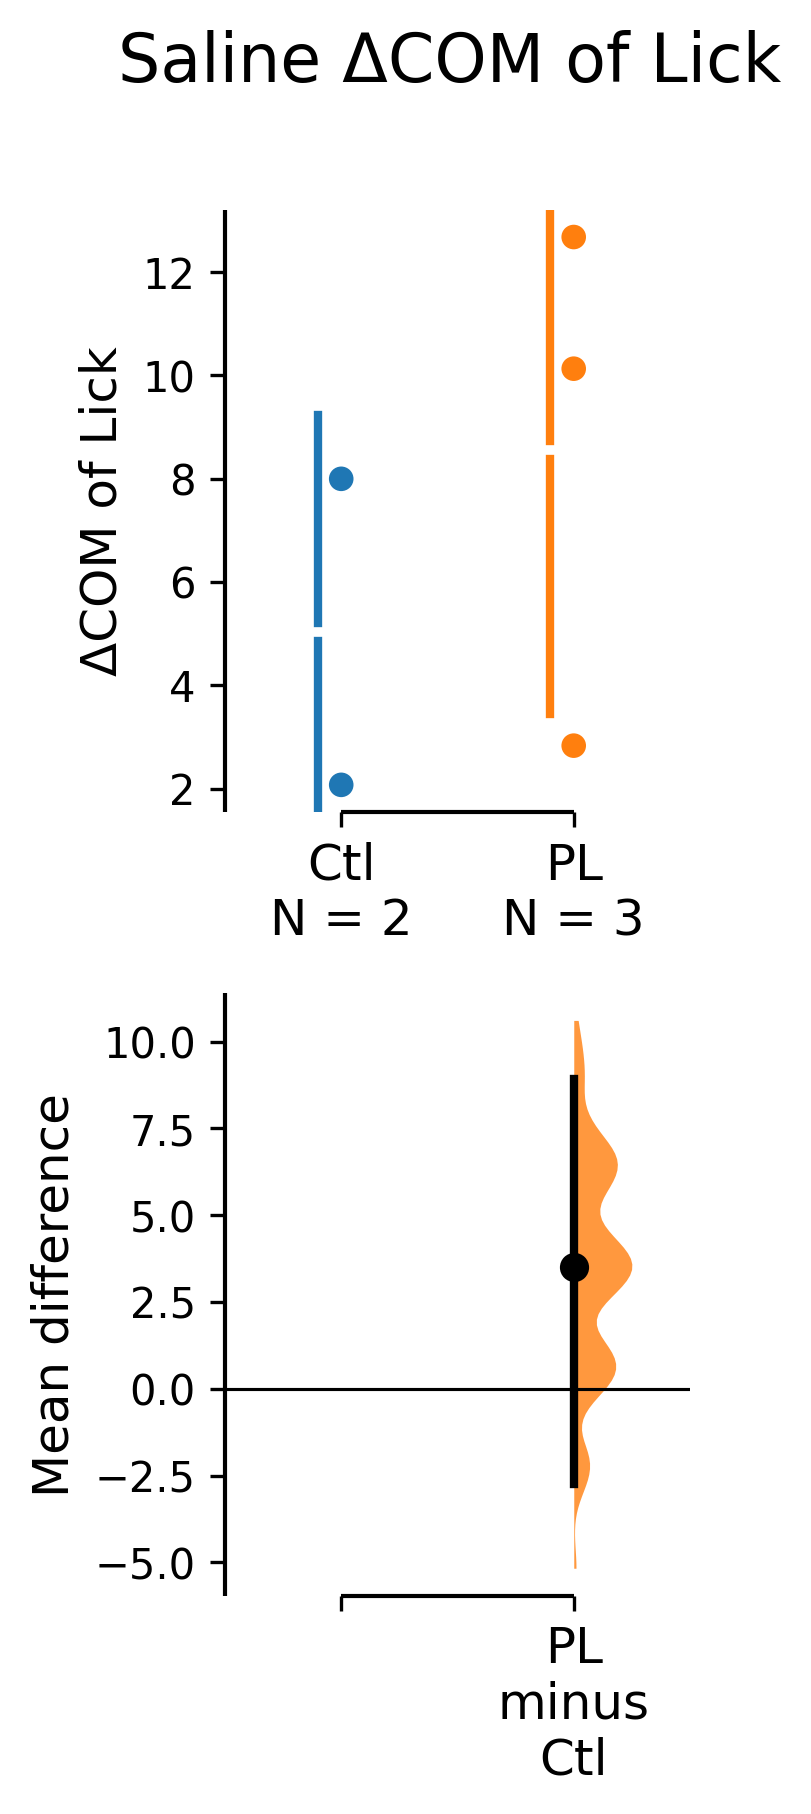

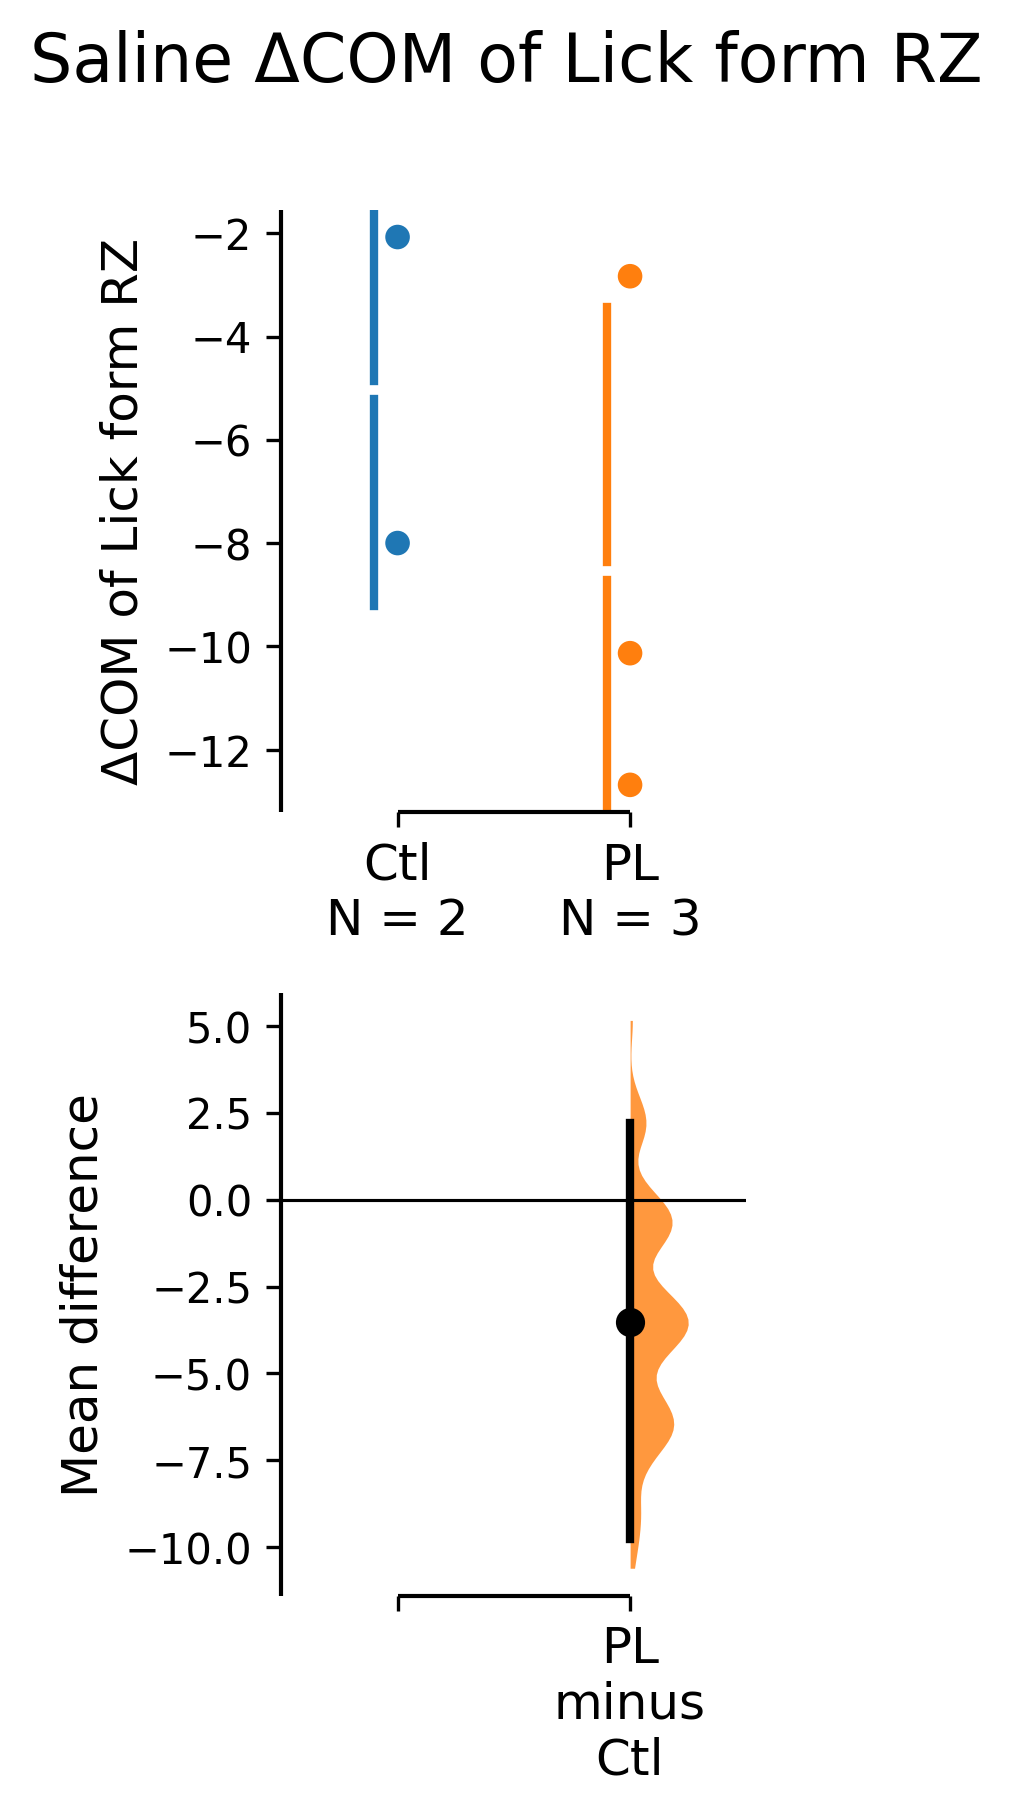

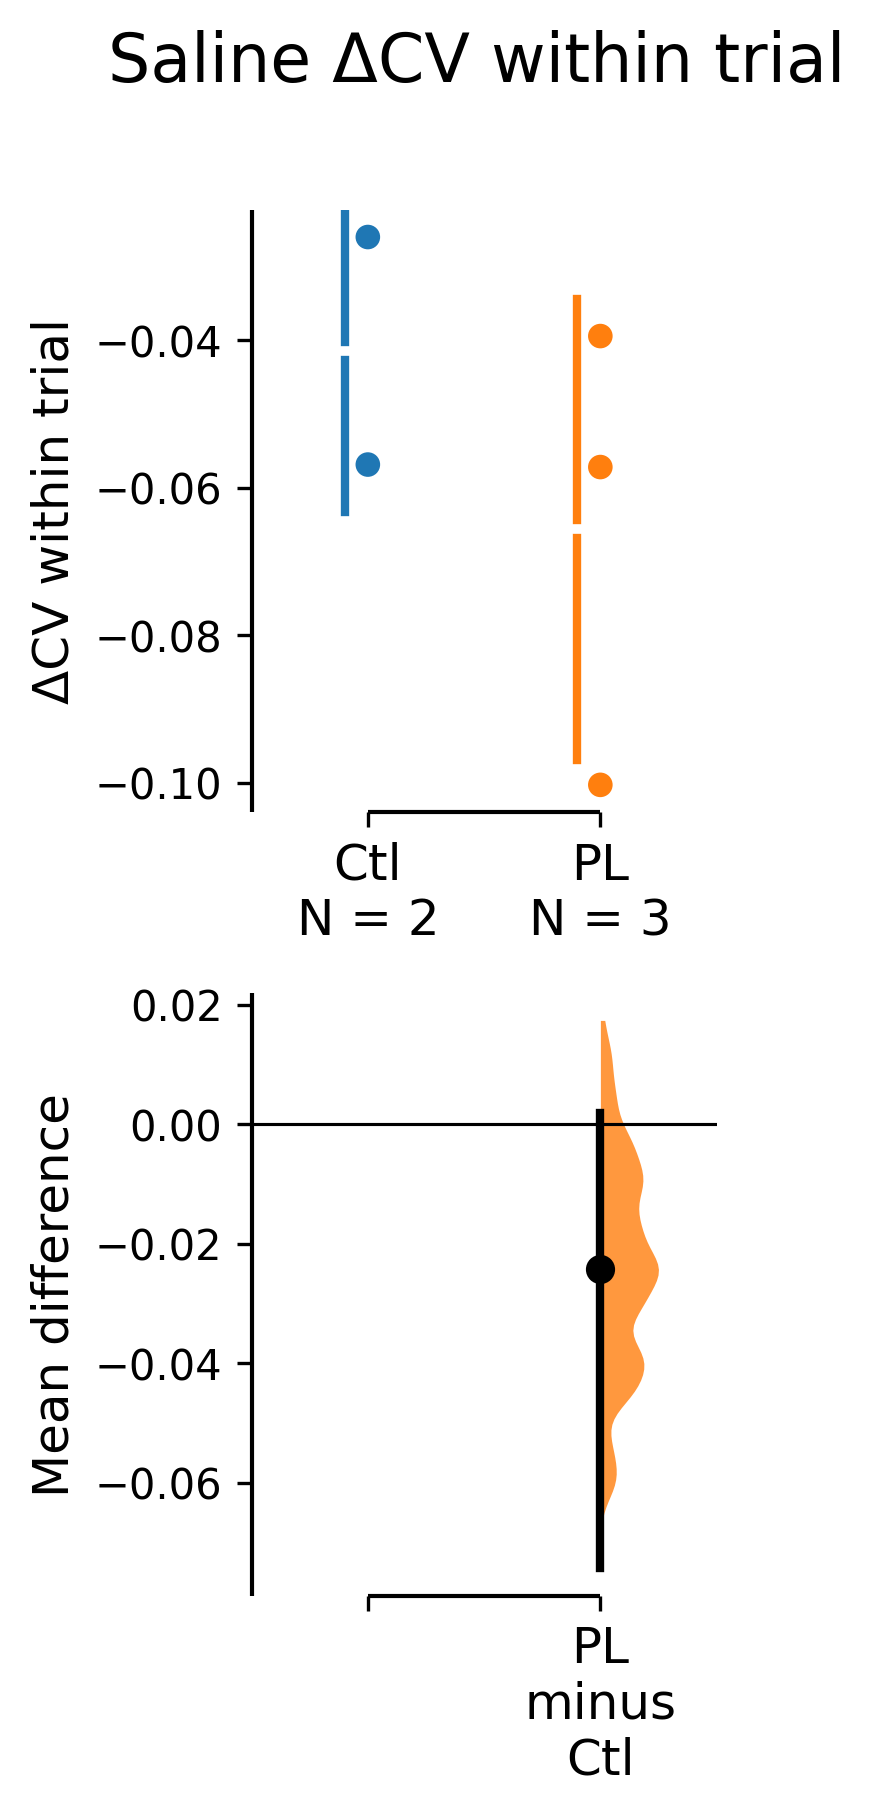

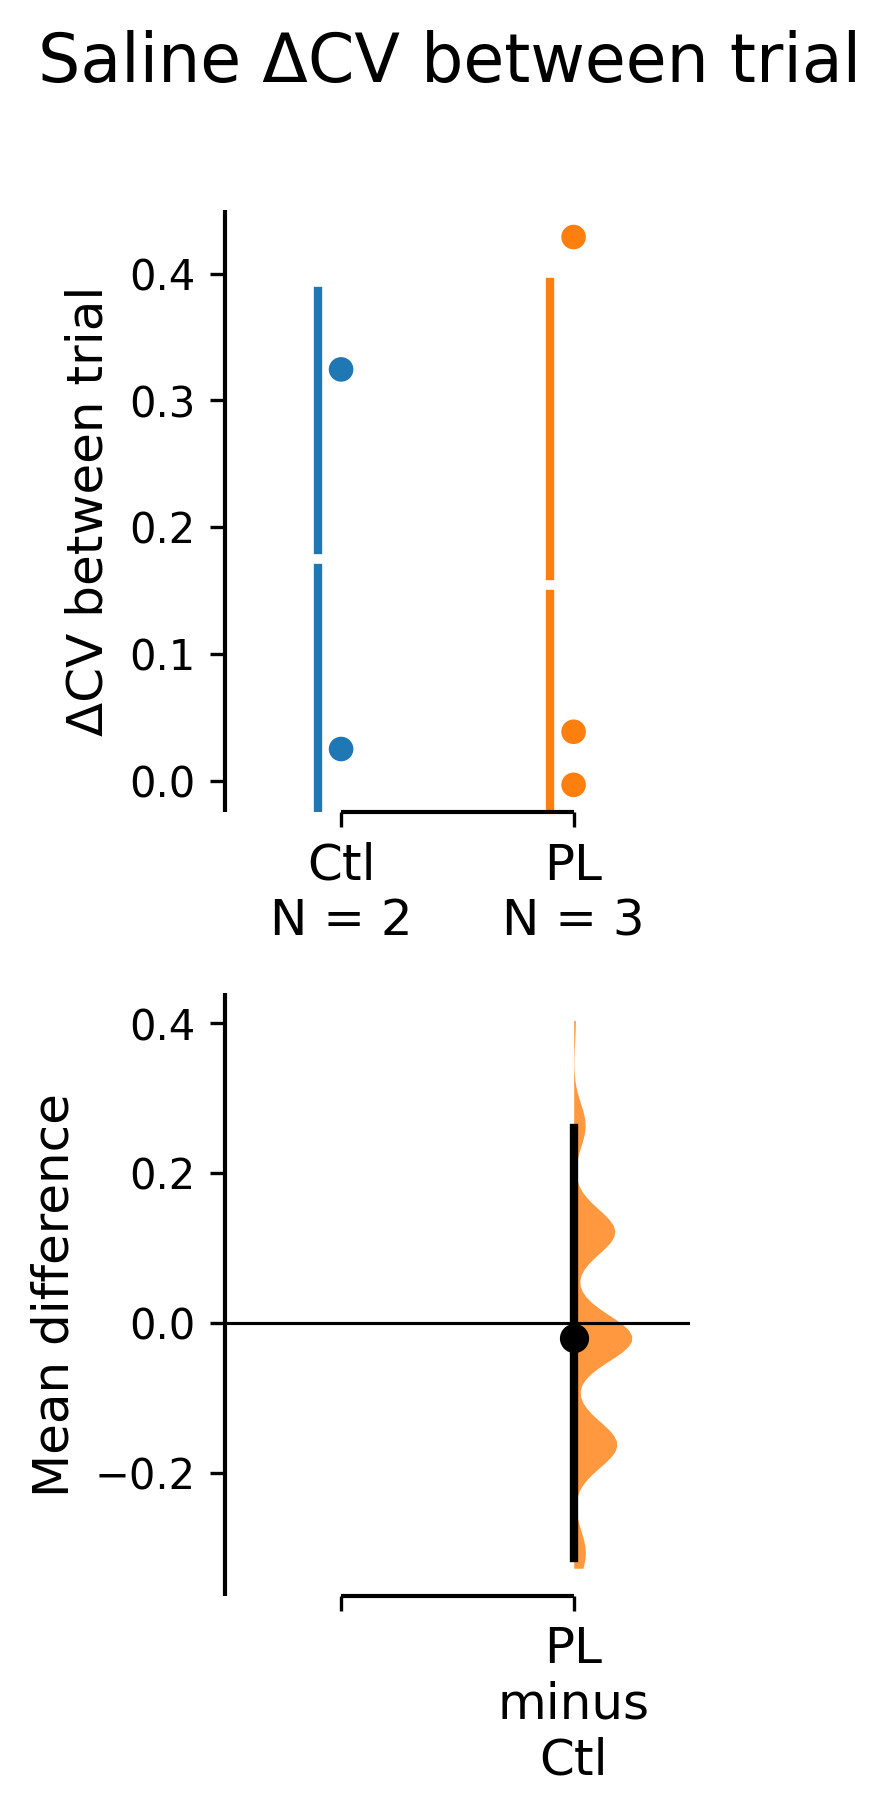

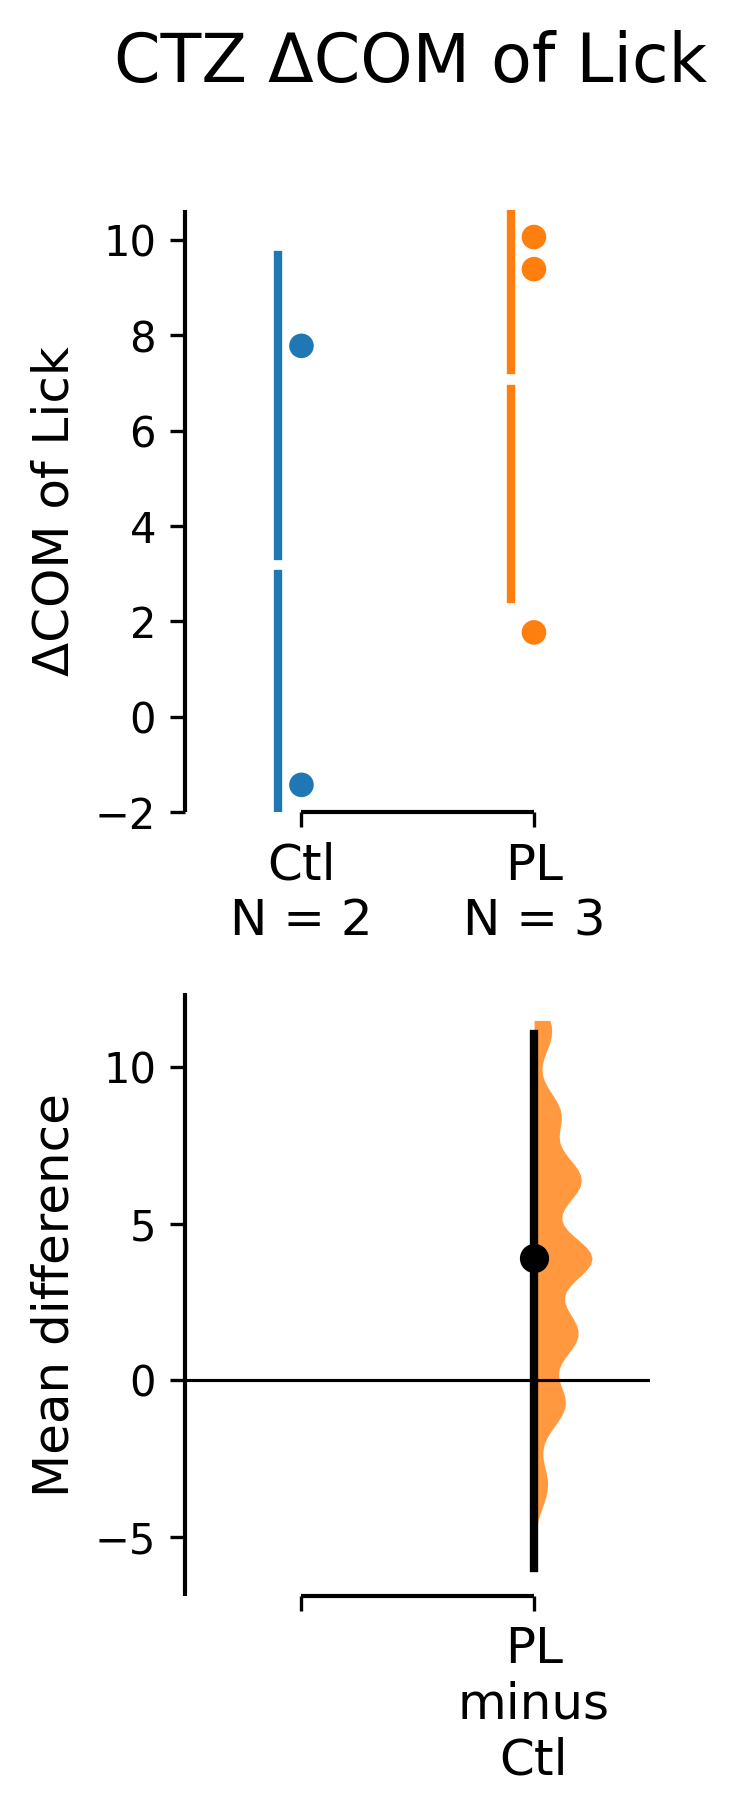

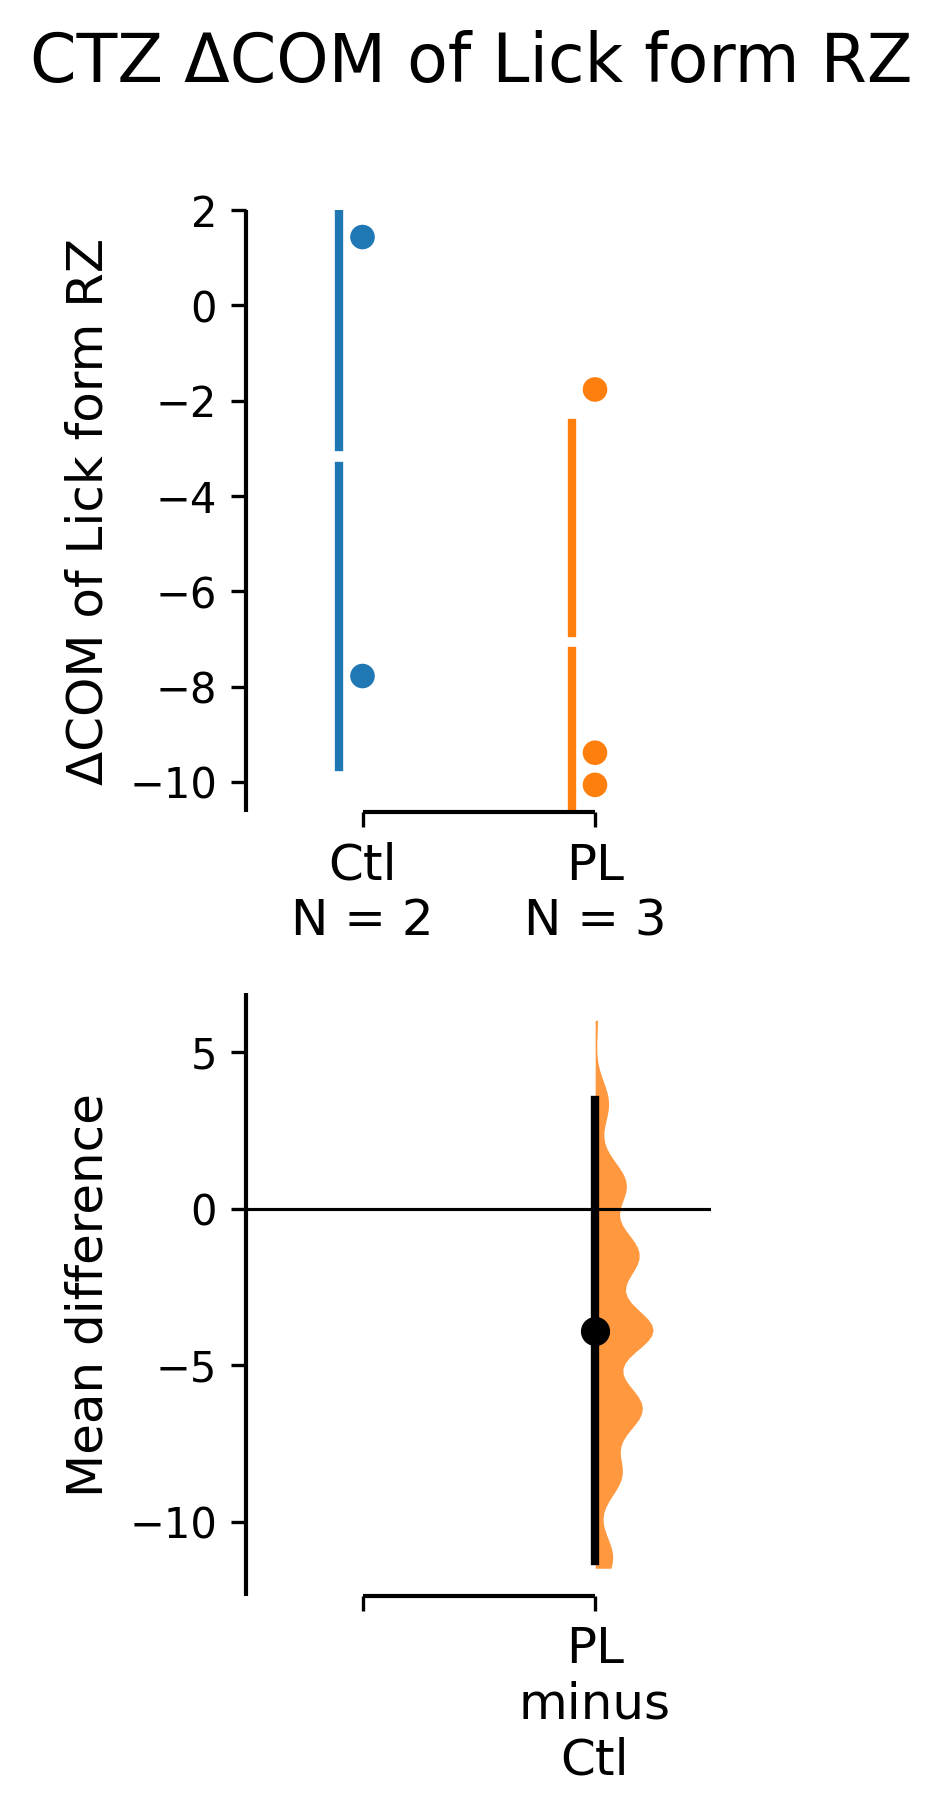

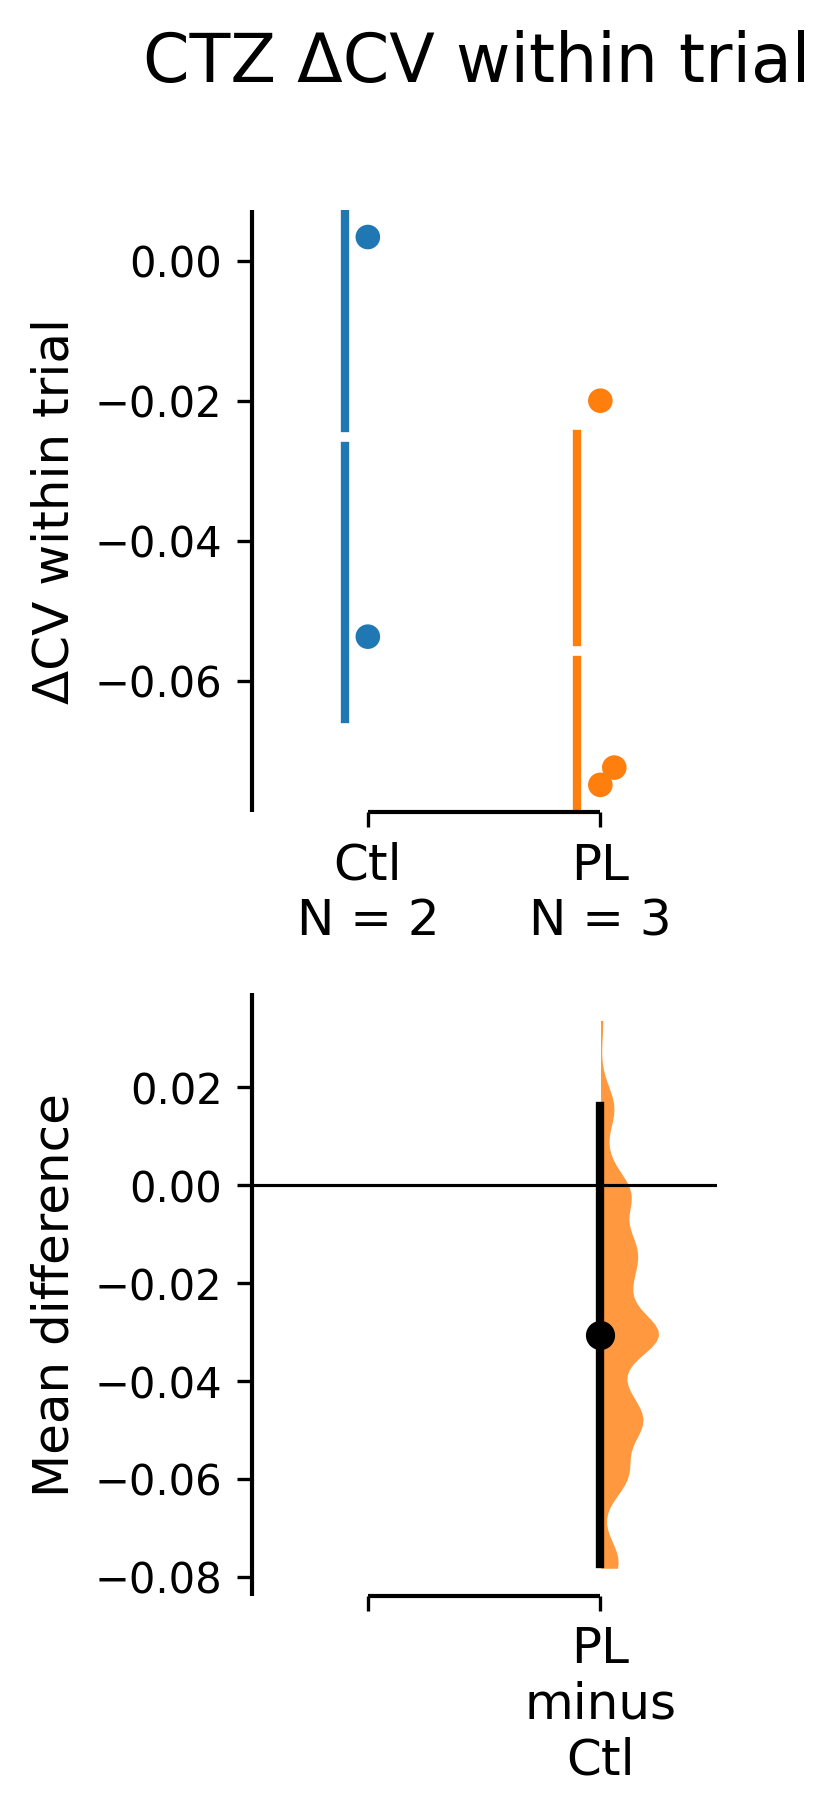

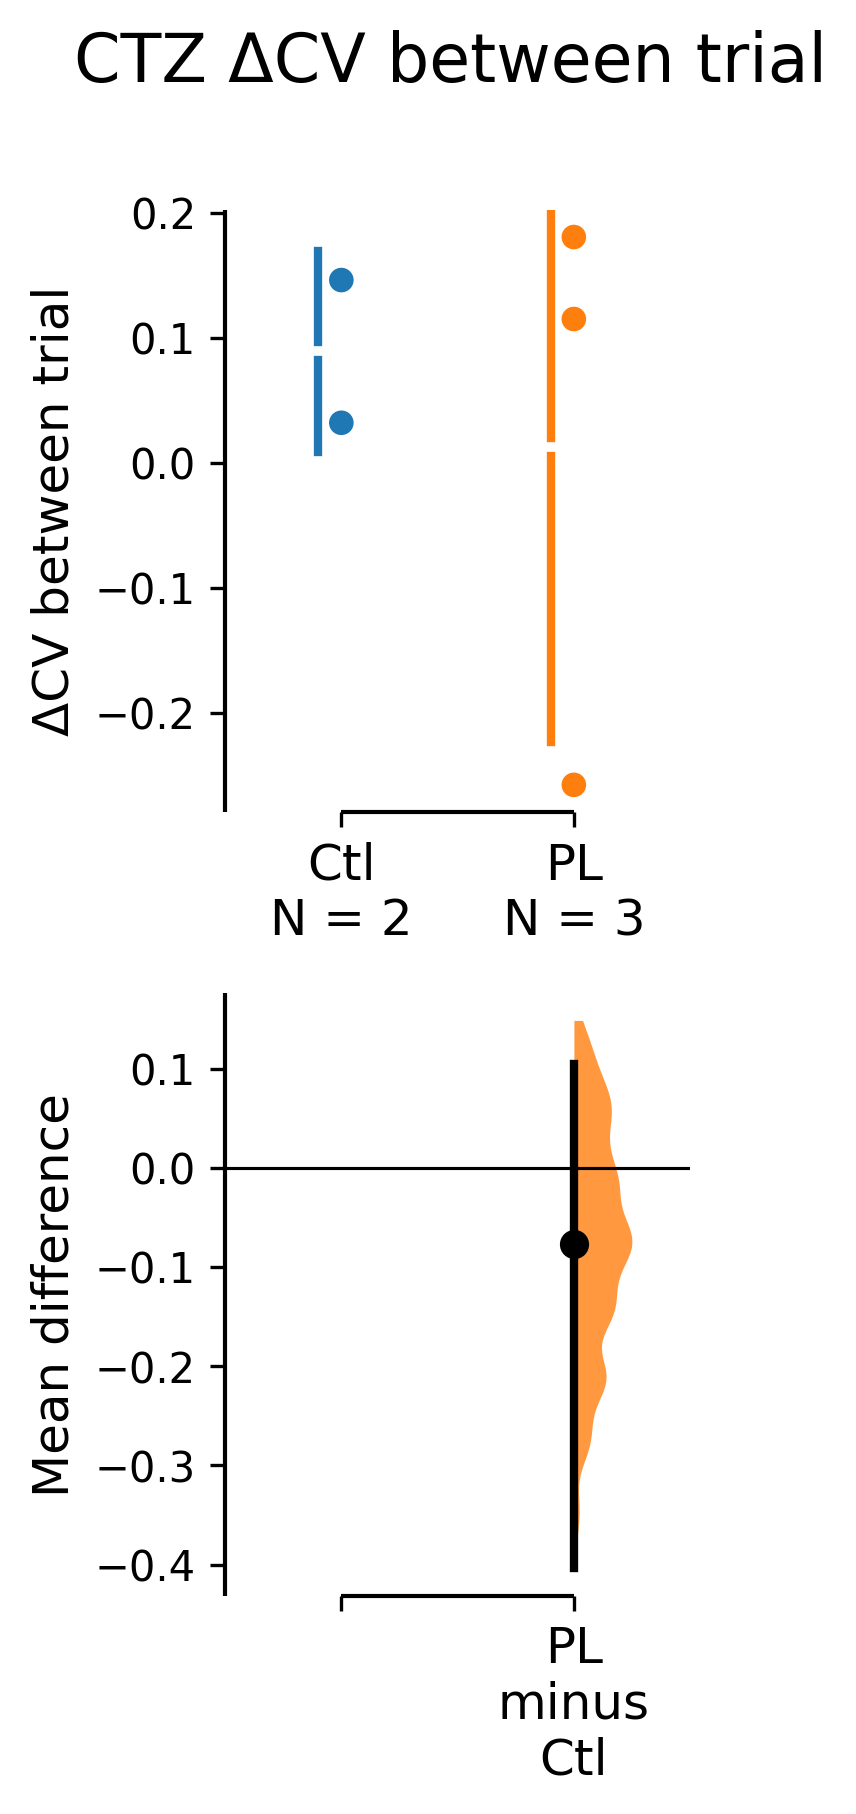

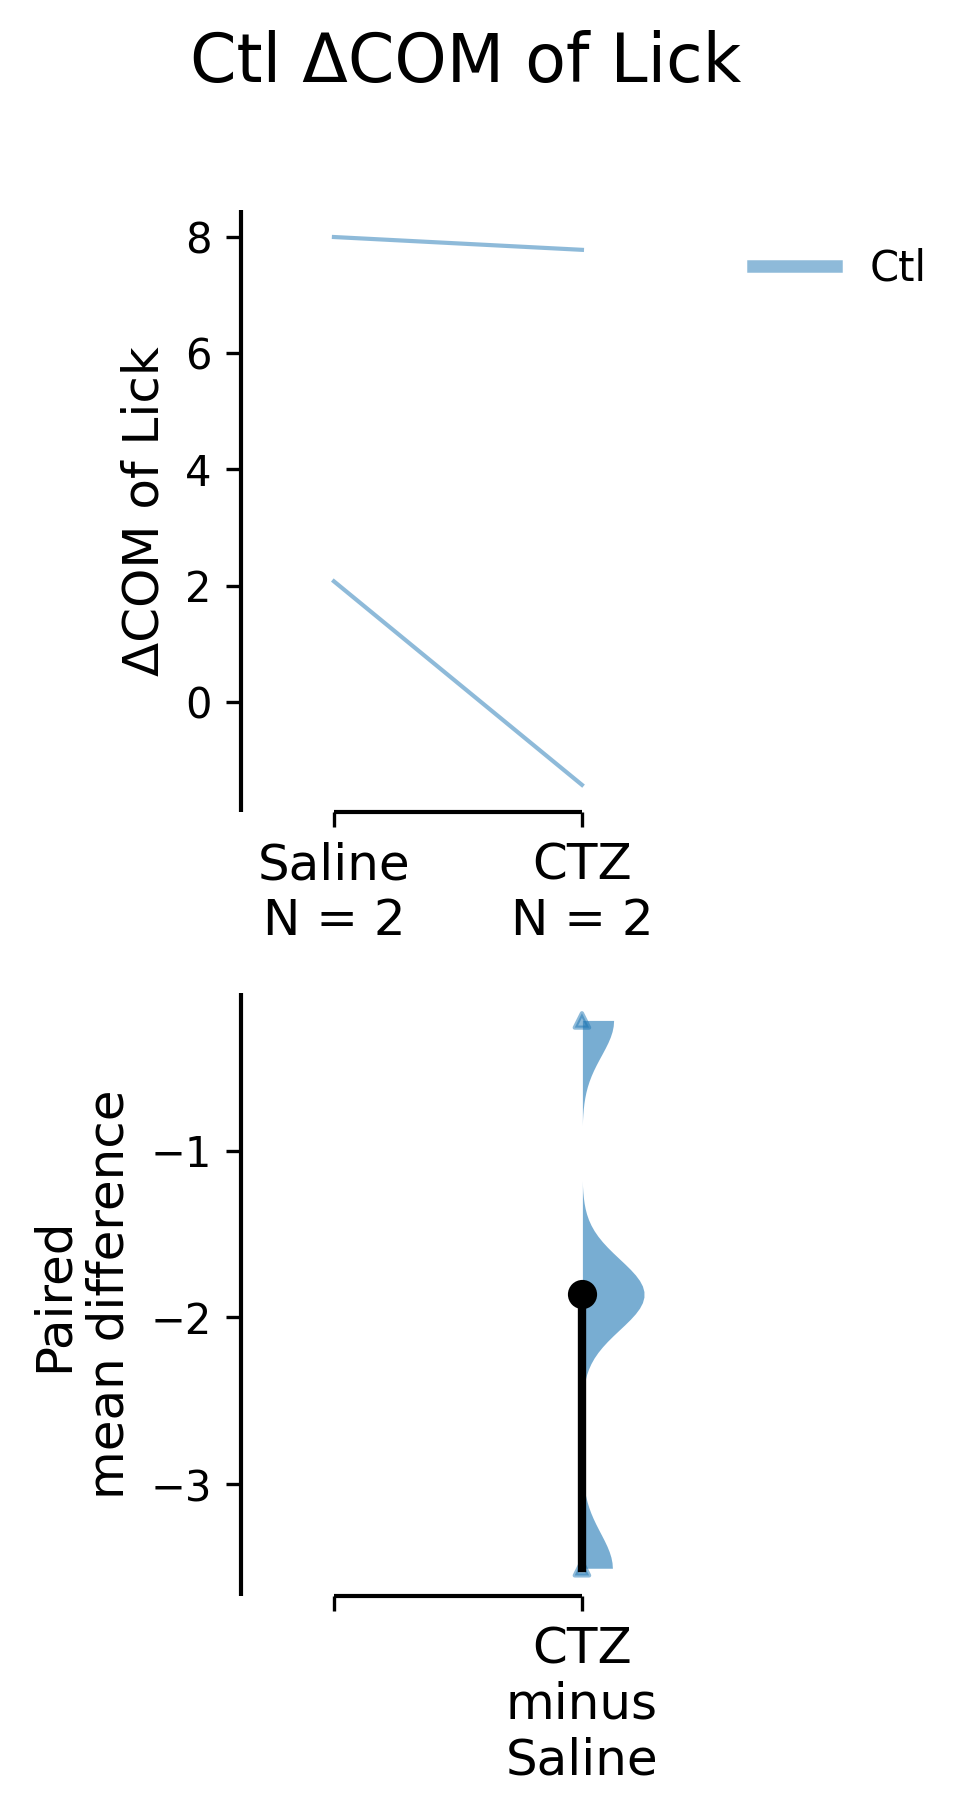

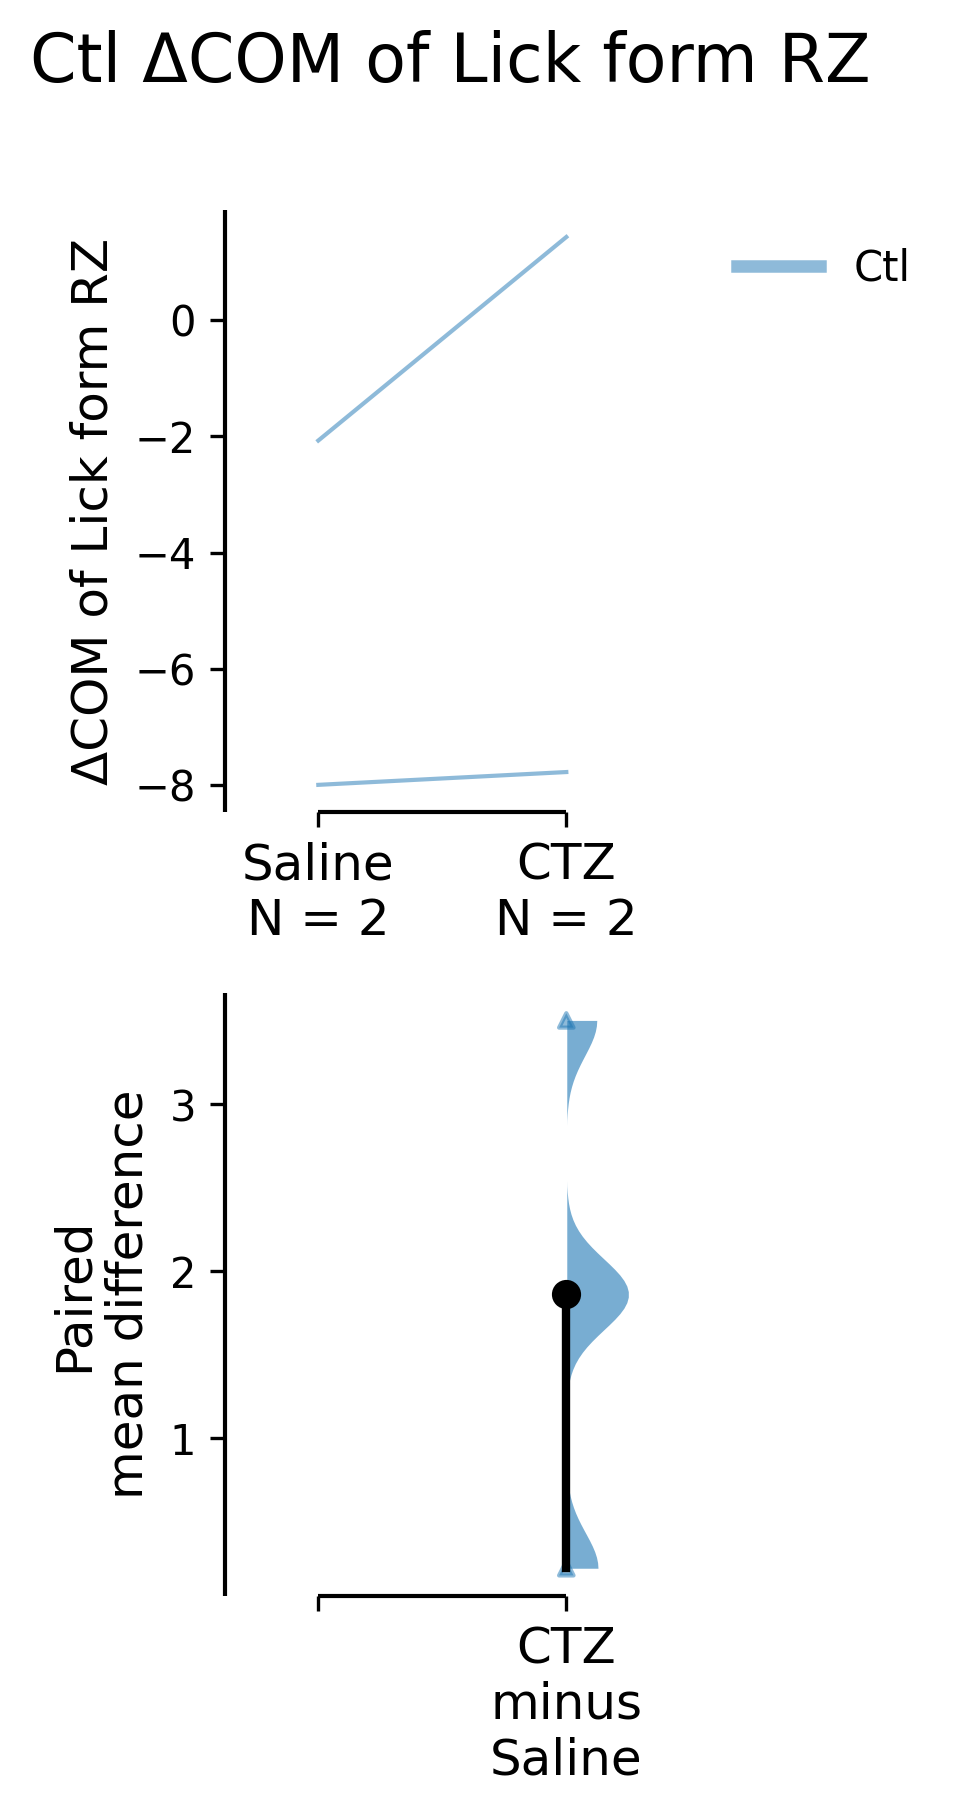

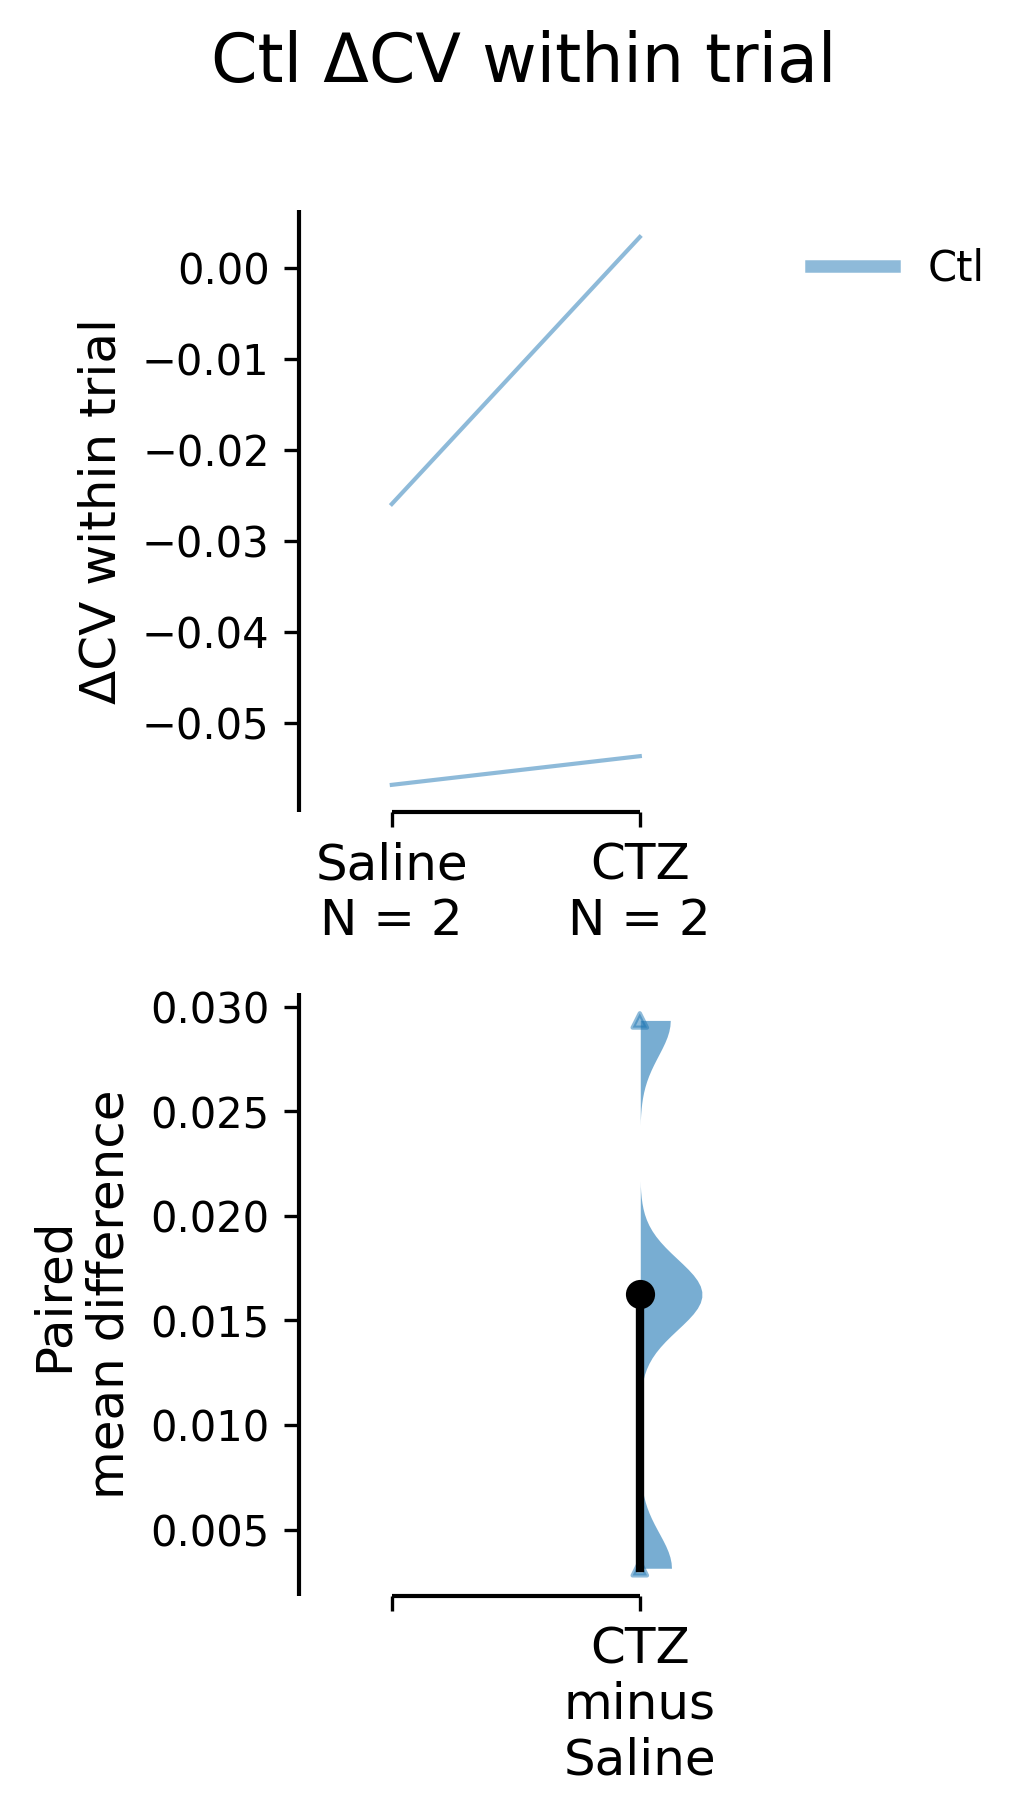

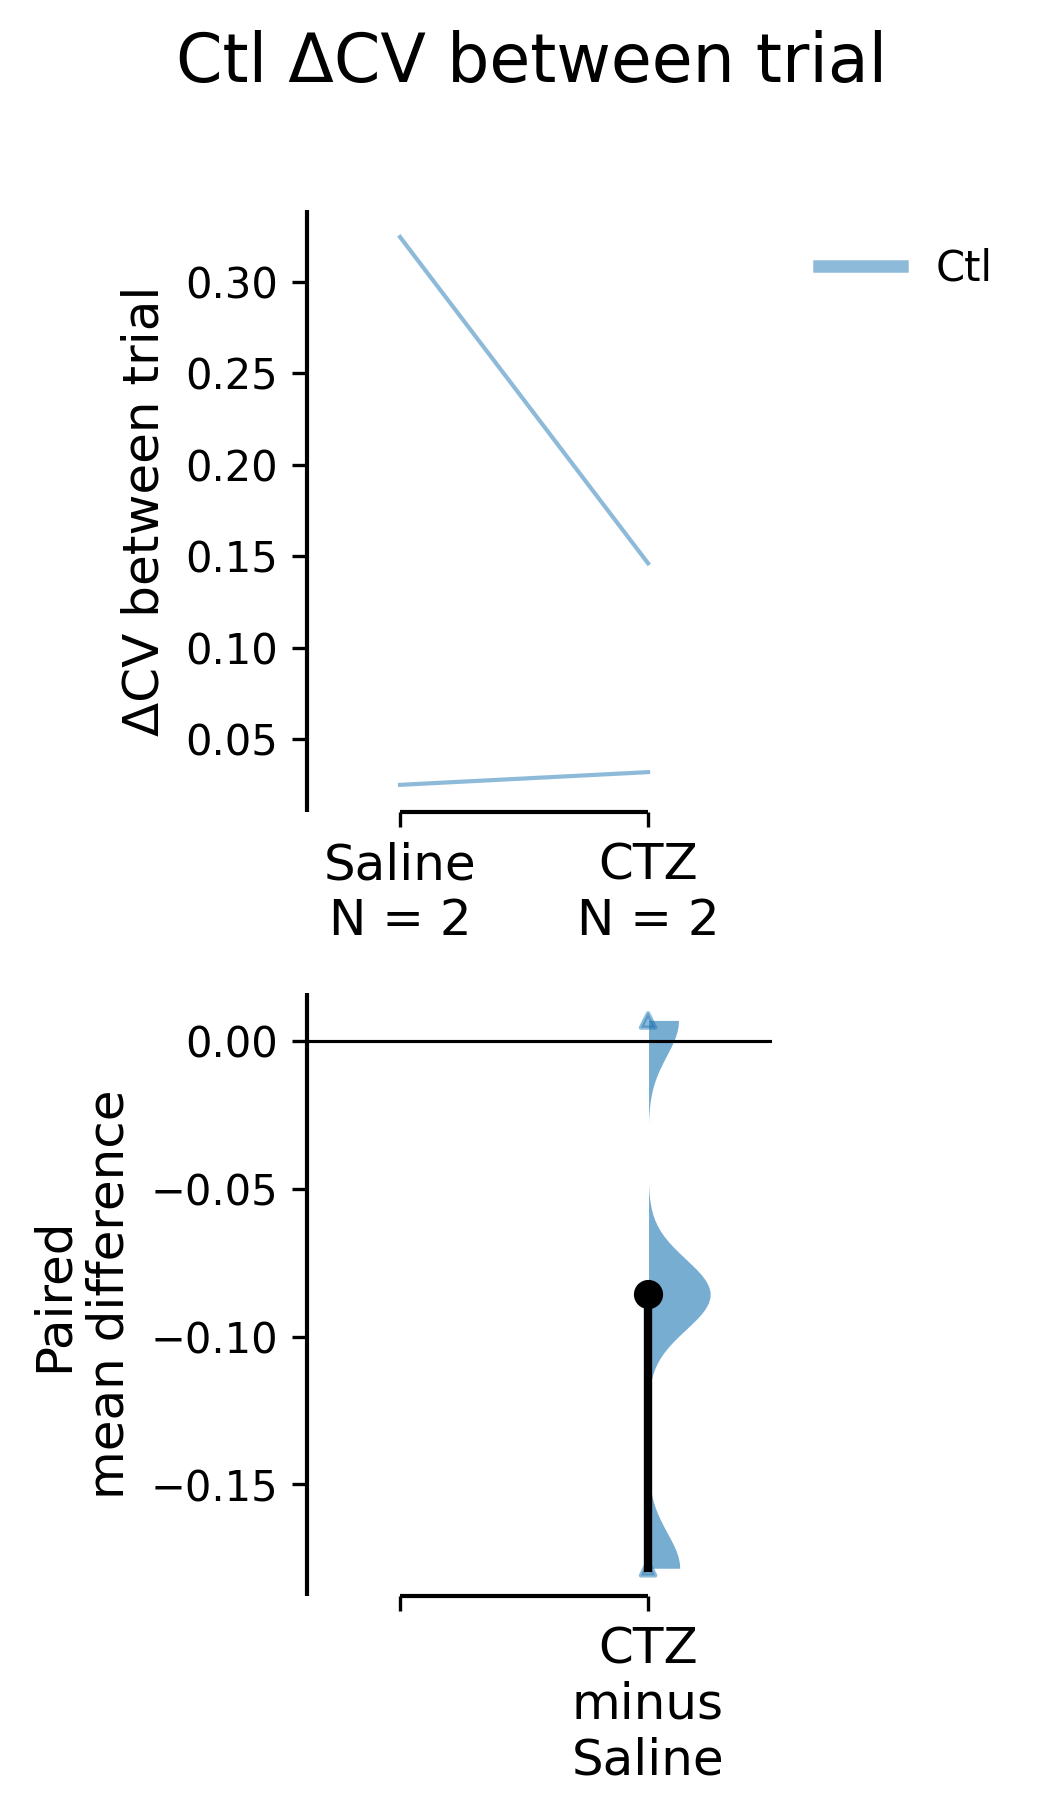

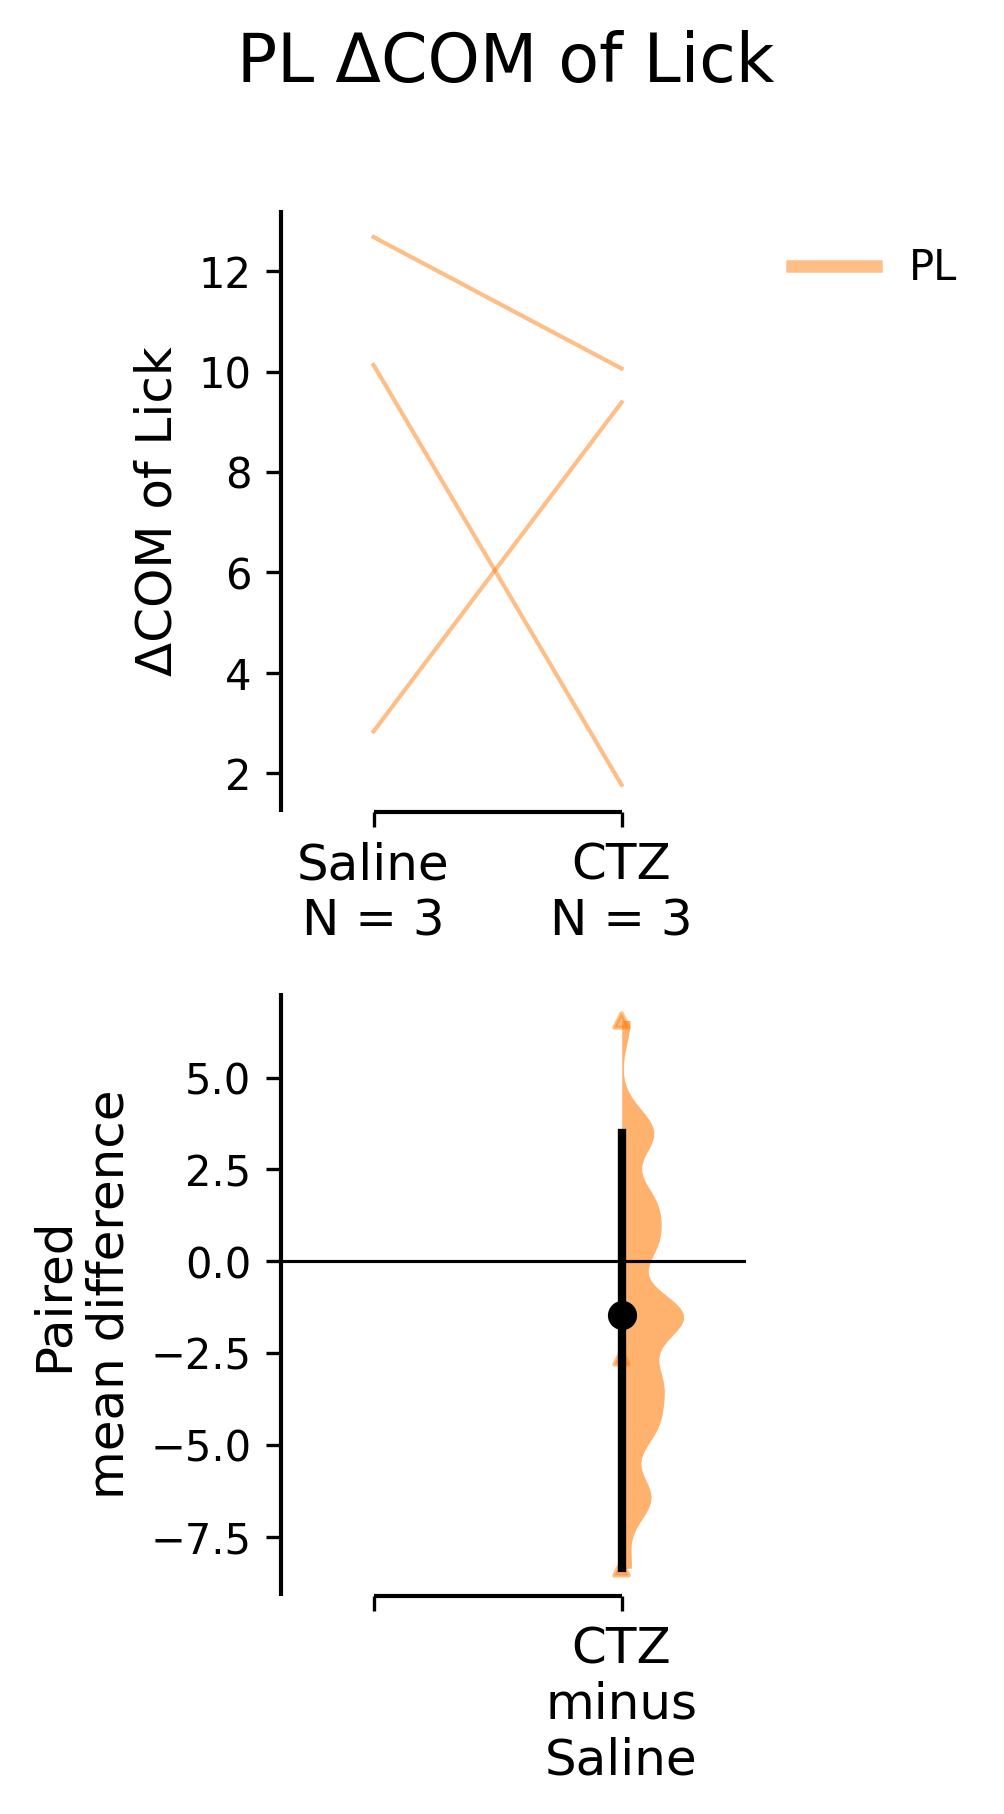

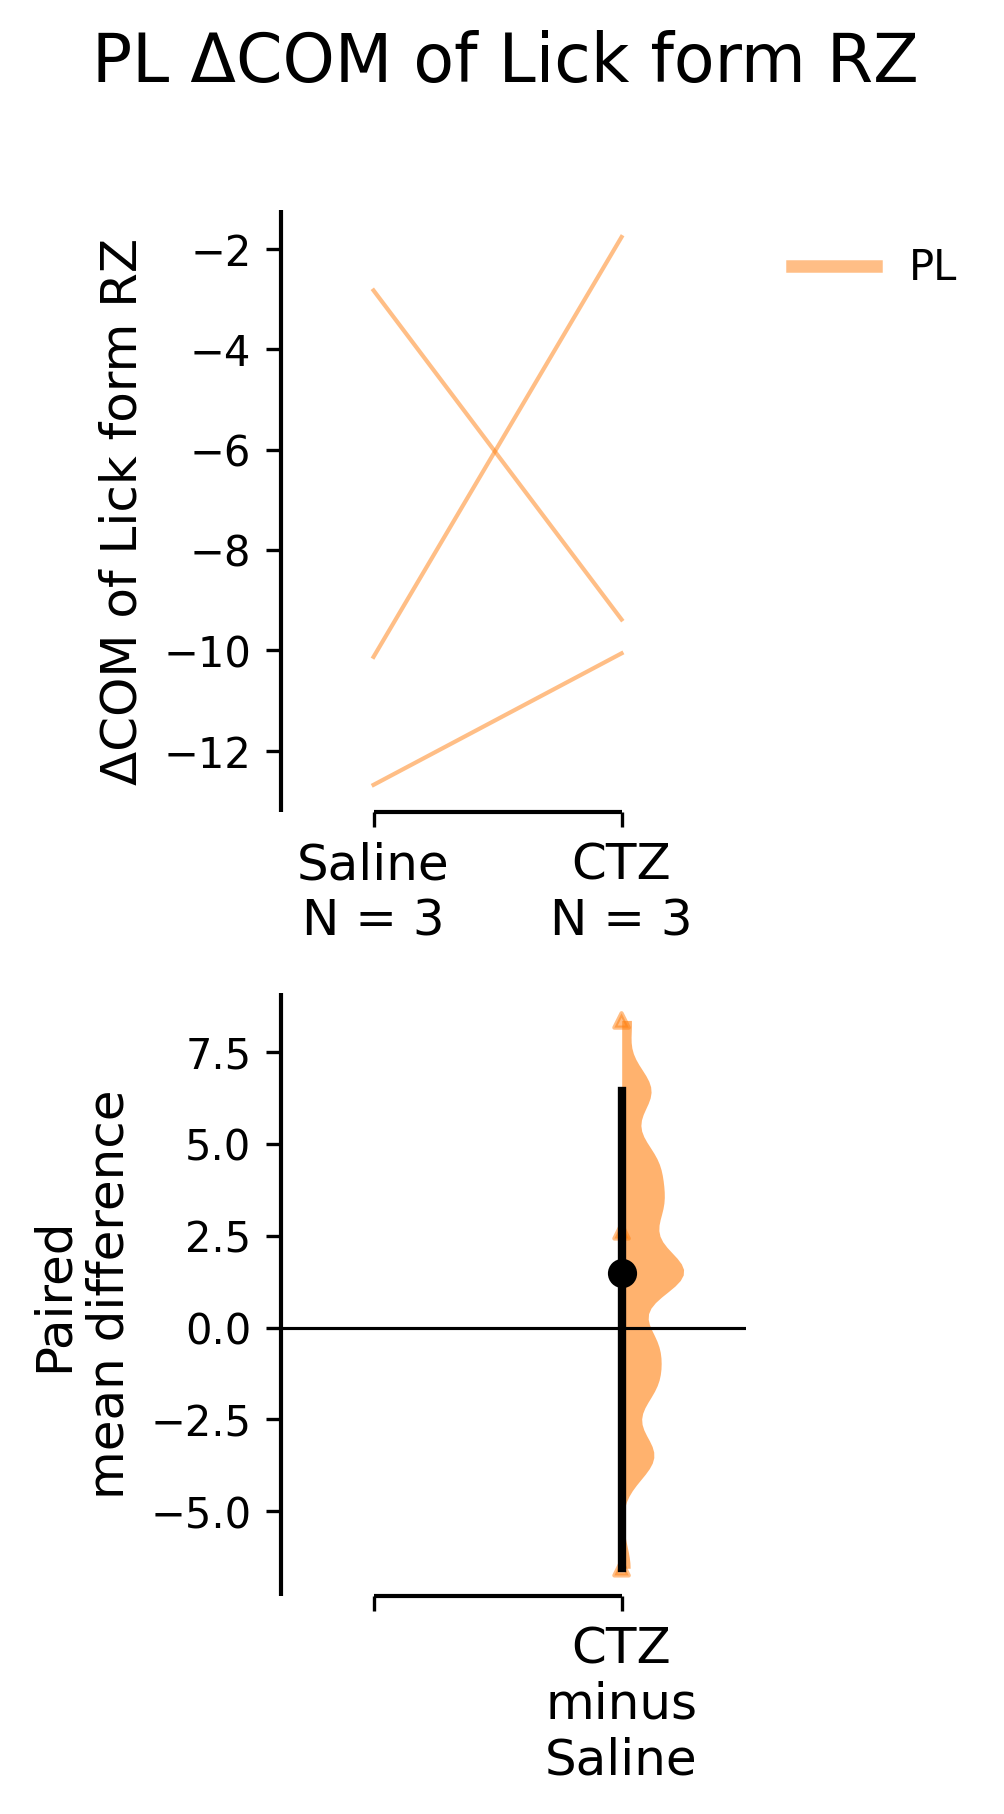

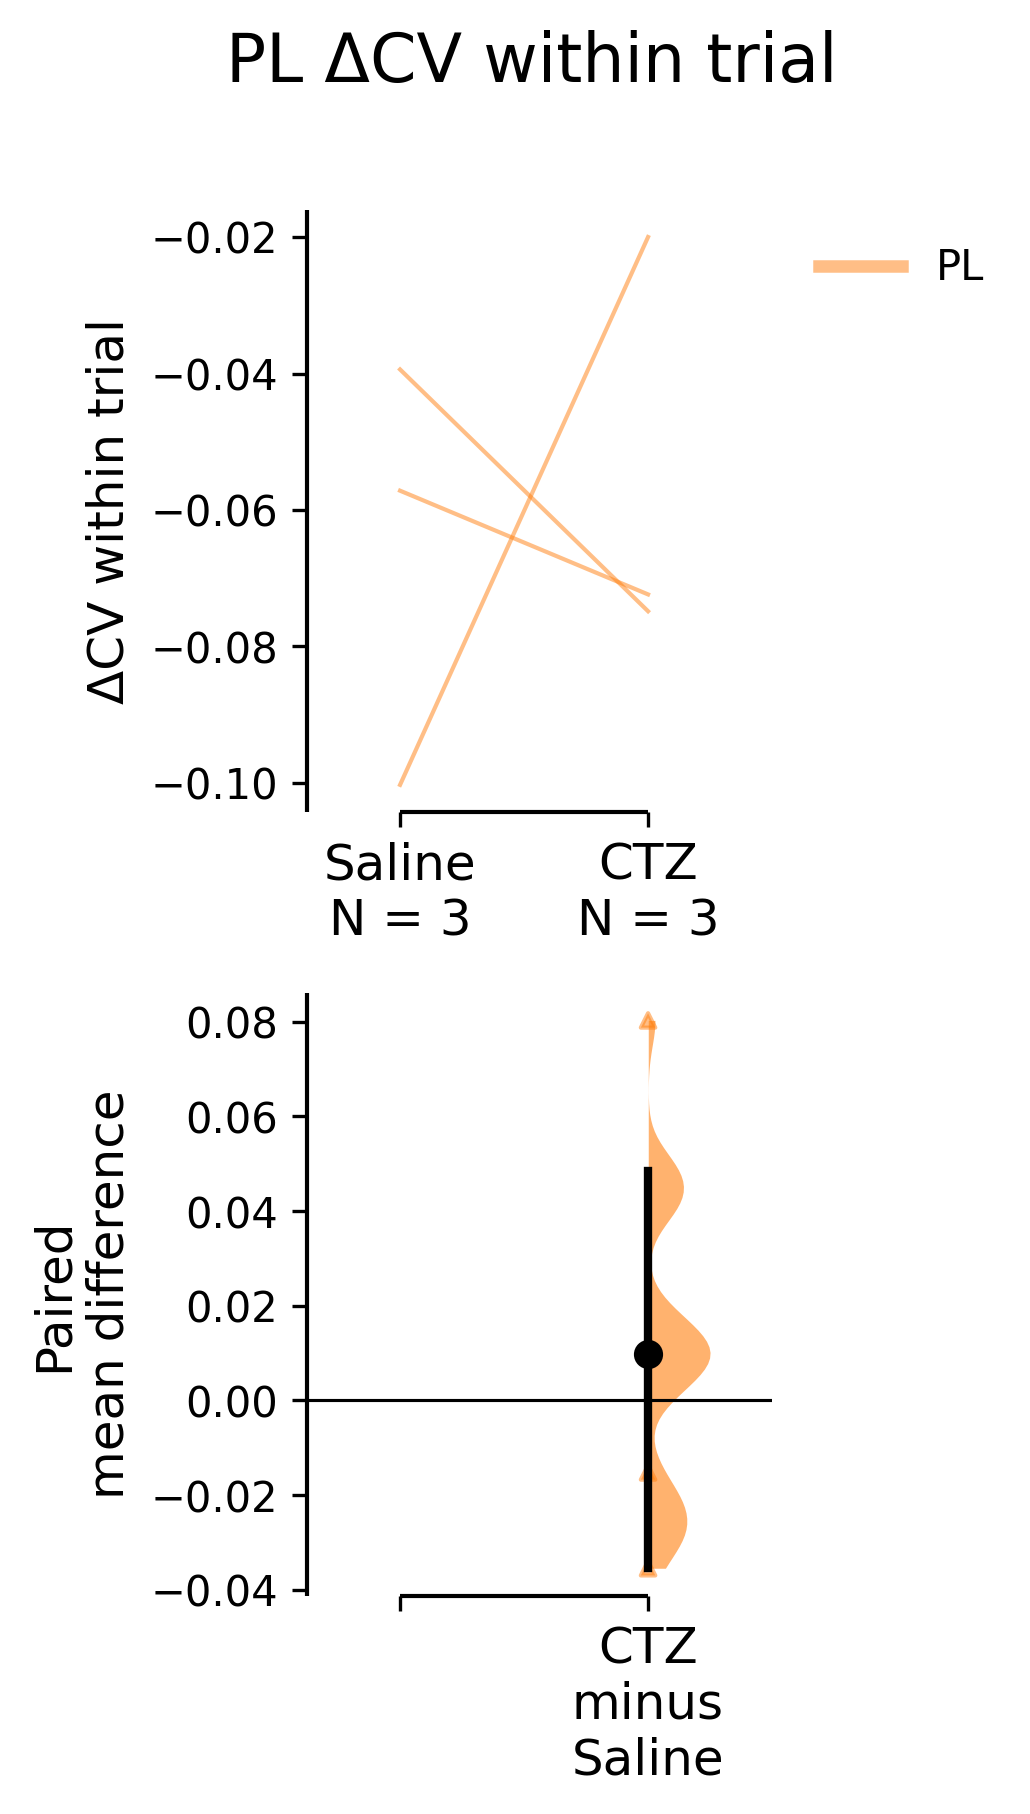

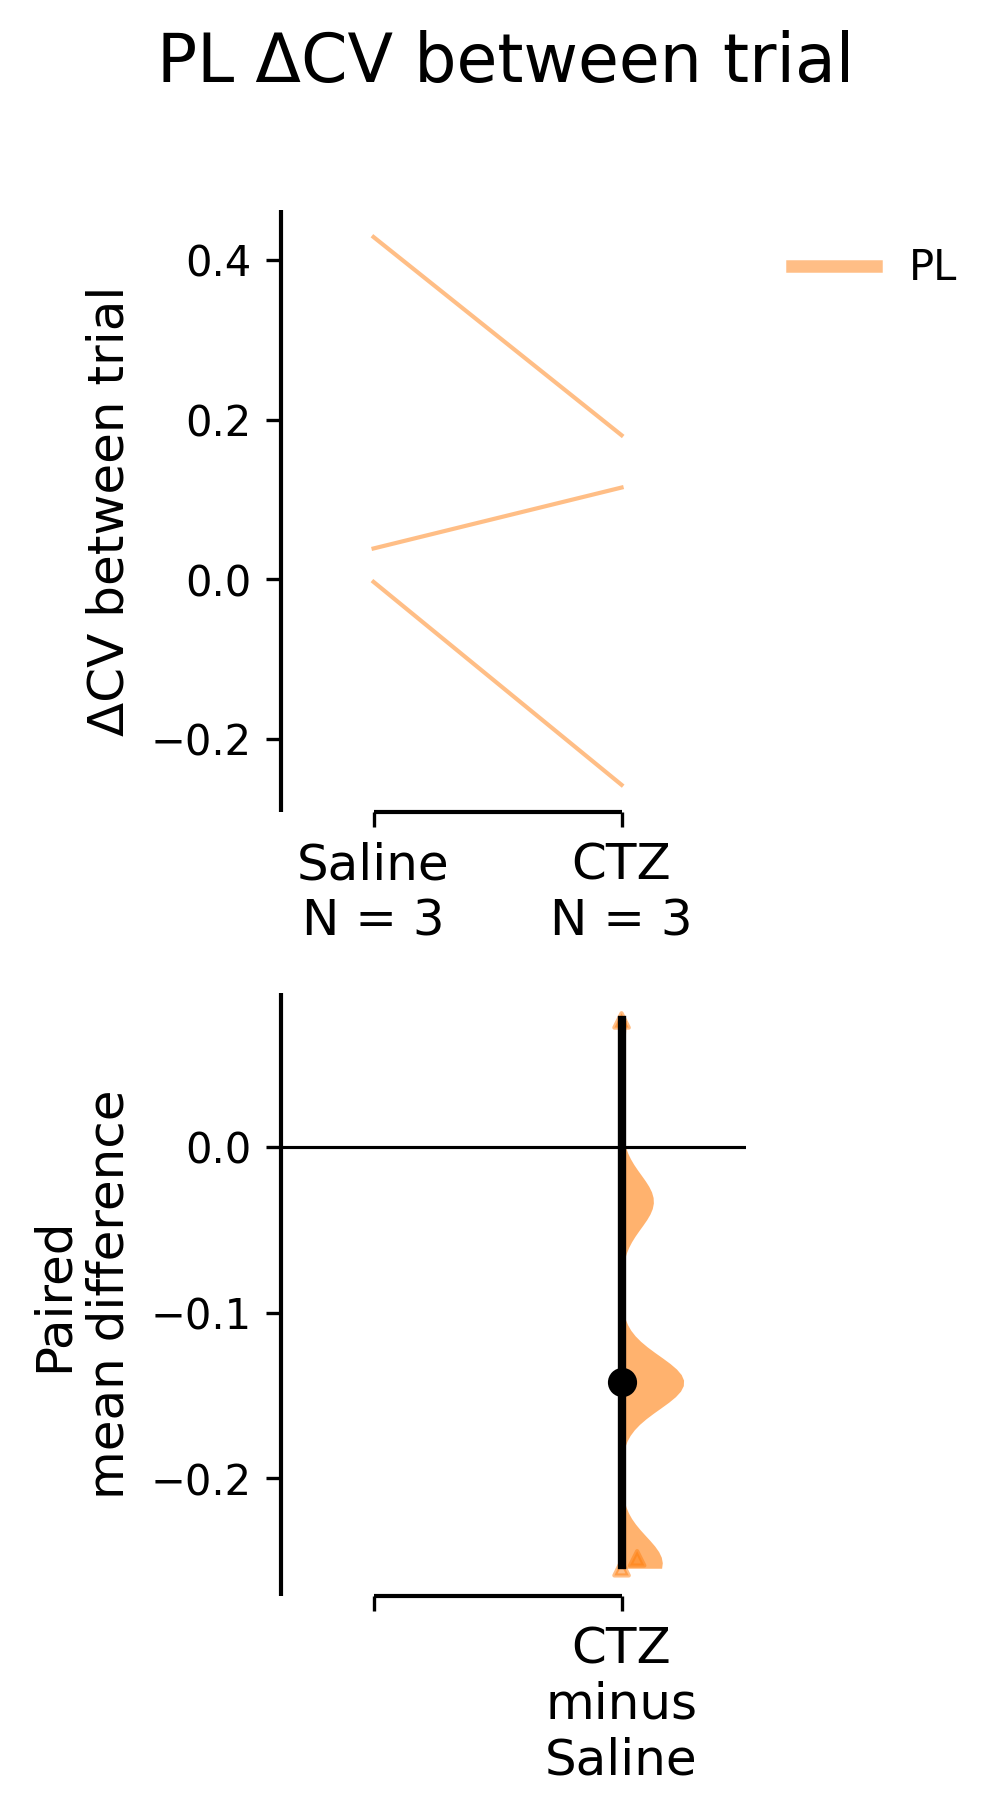

In [8]:
#Analyze and visualize delta stats
ControlTypes = ['Genotype', 'Treatment']
BehaviorParameters = ['ΔCOM of Lick', 'ΔCOM of Lick form RZ', 'ΔCV within trial', 'ΔCV between trial']

output_dir = "result of ip 400ug"
os.makedirs(output_dir, exist_ok=True)

for ControlType in ControlTypes:

    if ControlType == 'Genotype':
        CondictionName = ['Saline', 'CTZ']
    elif ControlType == 'Treatment':
        CondictionName = ['Ctl', 'PL']
    
    for CondictionName in CondictionName:

        for BehaviorParameter in BehaviorParameters:
            mean_diff, fig = analyze_and_visualize_delta_stats(delta_stats_data, ControlType, CondictionName, BehaviorParameter)

            # Save the stats and figure to files
            stats_output_path = os.path.join(output_dir, f"{CondictionName}_{BehaviorParameter}_stats.csv")
            mean_diff.to_csv(stats_output_path, index=False)
            fig.savefig(os.path.join(output_dir, f"{CondictionName}_{BehaviorParameter}.png"), dpi=300, bbox_inches='tight')
            print(f"Saved {CondictionName}_{BehaviorParameter}.png and stats to {output_dir}.")